# Definitions

* $ L $: Levels of simulation. $ x \in L$ and $ x \notin T \subsetneq L$
* $ L_{term} $: When $\forall x \in L_{term}. u_x = 1$, terminates the simulation. $ L_{term} \subseteq L $
* $ p_x $: A person on level-x.
* $ u_x $: Understanding of level-x person. $ 0 \leq u_x \leq 1 $.
* $ t_{x \rightarrow T} $: # of tells from level-y person to each person.
  * By doing $ t_{x \rightarrow T}$, $ u_y (y \in T) $ is increased by $ \frac{u_x}{\sqrt{|T|}} $

```mermaid
graph TD
    1[p_1, has u_1]
    subgraph team1[ ]
      11[p_2, has u_2] -- t_2->{3} -->
        l11[p_3, has u_3] & l12[p_3, has u_3]
      12[p_2, has u_2] -- t_2->{3} -->
      121[p_3, has u_3] & 122[p_3, has u_3]
    end
    1 -- t_1->{2} --> 11 & 12
    1 -- t_1->{2,3} --> team1

```

# Simulations

## Top-down message to members

It means,

* $ | p_1 | = 1 $
* For $ t_{x \rightarrow Y} $, $ \forall y \in Y. x \lt y $
* $ u_1 = 1$

### 1-level
* $ L = \{1\}$
* $ L_{term} = \{1\}$
* $ t_{x \rightarrow Y} $ cannot be defined.

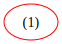

In [54]:
import pygraphviz as pgv

G = pgv.AGraph(directed=True)
G.add_node("1", label="(1)", color="red")

G.layout()
G

### 2-level
* $ L = \{1,2\} $
* $ L_{term} = \{1,2\} $
* $ t_{1 \rightarrow \{2\}} = \frac{u_1}{\sqrt{|p_2|}} $

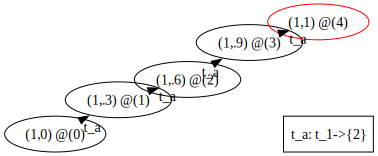

In [1]:
import pygraphviz as pgv

num_p_2 = 10

# TODO automate
G = pgv.AGraph(directed=True)
G.add_node("1", label="(1,0) @(0,0)")
G.add_node("2", label="(1,.3) @(1,0)")
G.add_node("3", label="(1,.6) @(2,0)")
G.add_node("4", label="(1,.9) @(3,0)")
G.add_node("5", label="(1,1) @(4,0)", color="red")
G.add_edge("1", "2", label="t_a")
G.add_edge("2", "3", label="t_a")
G.add_edge("3", "4", label="t_a")
G.add_edge("4", "5", label="t_a")

legend = G.add_subgraph(name="legend", label="Legend", shape="rectangle", color="black")
legend.add_node("ddd", shape="rectangle", label="t_a: t_1->{2}")

G.layout()
G

### 3-level, until p_2 understands
* $ L = \{1,2,3\} $
* $ L_{term} = \{1,2\} $
* $ t_{1 \rightarrow \{2\}} = \frac{u_1}{\sqrt{|p_2|}} $
* $ t_{1 \rightarrow \{2,3\}} = \frac{u_1}{\sqrt{|p_2|+|p_3|}} $

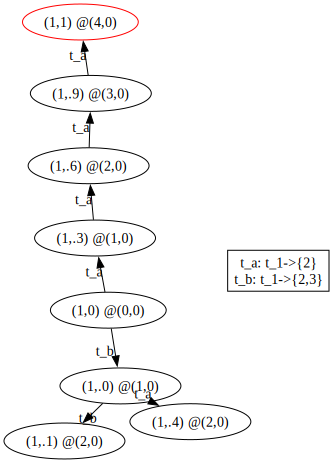

In [1]:
import pygraphviz as pgv

num_p_2 = 10
num_p_3 = 10 * 10

G = pgv.AGraph(directed=True)
G.add_node("1", label="(1,0) @(0,0)")
G.add_node("2", label="(1,.3) @(1,0)")
G.add_node("3", label="(1,.6) @(2,0)")
G.add_node("4", label="(1,.9) @(3,0)")
G.add_node("5", label="(1,1) @(4,0)", color="red")
G.add_node("6", label="(1,.0) @(1,0)")
G.add_node("7", label="(1,.4) @(2,0)")
G.add_node("8", label="(1,.1) @(2,0)")
G.add_edge("1", "2", label="t_a")
G.add_edge("2", "3", label="t_a")
G.add_edge("3", "4", label="t_a")
G.add_edge("4", "5", label="t_a")
G.add_edge("1", "6", label="t_b")
G.add_edge("6", "7", label="t_a")
G.add_edge("6", "8", label="t_b")
# TODO

legend = G.add_subgraph(name="legend", label="Legend", shape="rectangle", color="black")
legend.add_node("ddd", shape="rectangle", label="t_a: t_1->{2}\nt_b: t_1->{2,3}")

G.layout()
G